In [28]:
# Преоразовать существующий код для распознавания последовательности рукописных символов в текст.
# Написать генератор произвольной последовательности рукописных символов.

# ГЕНЕРАЦИЯ НАБОРА ДАННЫХ
# Сгенерировать набор текстовых строк из допустимых символов.
# Каждому набору поставить в соотвествие массив изоражений соответствующих символов.
# Добавить пробелы для разделения слов, символы пробелов не использовать во время классификации.

# КЛАССИФИКАЦИЯ (k ближайших соседей) (пример AIM practice 2)
# Часть символов оставить для обучения классификатора . Остальные  классифицировать
# по аналогии с примером mnist с прошлого занятия. Т.е. преобразовывать изображение в вектор.
# Выбрать оптимальный классификатор в зависимости от k- количество соседей.
# Метрика для измерения точности классификации, и выбора оптимального классификатора относительно параметра k - accuracy.

# РАСПОЗНАВАНИЕ
# заменить inf_net на последовательное применение следующих шагов:
# 1. генерация изображения с последовательностью символов
# 2. Выделение объектов оставляете как есть.
# 3. Примернить k-nn для решения задачи классификации. 
# 4. Вывести результат

In [29]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle, choice, randint
from collections.abc import Iterator
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import scripts.visual as visual

# ГЕНЕРАЦИЯ НАБОРА ДАННЫХ

## Функция предобработки

## Датасет

In [30]:
class CharDataset:
    """
    Датасет для загрузки и хранения изображений символов
    """
    
    def __init__(self, data_path, img_size=45, max_images_per_char=50):
        self.data_path = data_path
        self.img_size = img_size
        self.max_images_per_char = max_images_per_char
        
        self.name_folders = self._get_character_folders(data_path)
        self.available_chars = self._replace_times_with_asterisk(self.name_folders)
        
        self.char_images = self._load_preprocess_images()

    @staticmethod
    def _get_character_folders(data_path):
        character_folders = []
        
        items = os.listdir(data_path)
        character_folders = [item for item in items]
        character_folders.sort()
        return character_folders

    @staticmethod
    def _replace_times_with_asterisk(name_folders):
        replaced_chars = []
        for char in name_folders:
            if char == 'times':
                replaced_chars.append('*')
            else:
                replaced_chars.append(char)
        return replaced_chars

    def _load_preprocess_images(self):
        char_images = {}
        
        for original_char, display_char in zip(self.name_folders, self.available_chars):
            char_path = os.path.join(self.data_path, original_char)
            images = []
            
            # Получаем список всех файлов и перемешиваем
            all_files = [f for f in os.listdir(char_path) 
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            
            # Ограничиваем количество загружаемых файлов
            files_to_load = all_files[:self.max_images_per_char]
            
            for file in files_to_load:
                img_path = os.path.join(char_path, file)
                img = cv2.imread(img_path)
                
                if img is not None:
                    if (img.shape[0] != self.img_size):
                        img = cv2.resize(img, (self.img_size, self.img_size))
                    images.append(img)
            
            char_images[display_char] = images
        return char_images
    
    def get_random_char_image(self, char):
        images = self.char_images.get(char, [])
        return choice(images) if images else None
    
    def get_all_data(self):
        X = []
        y = []
        
        for char_idx, char in enumerate(self.available_chars):
            for img in self.char_images[char]:
                X.append(img)
                y.append(char_idx)
        
        return np.array(X), np.array(y), self.available_chars
    
    def __len__(self):
        total = 0
        for images in self.char_images.values():
            total += len(images)
        return total
    

    # Для вывода
    def __repr__(self):
        return f"CharDataset(data_path='{self.data_path}', " \
               f"img_size={self.img_size}, chars={len(self.available_chars)}, " \
               f"total_images={len(self)}, max_per_char={self.max_images_per_char})"
    
    def print_loading_stats(self):
        """Выводит статистику по загруженным изображениям"""
        total_images = 0
        print("\nСтатистика загрузки изображений:")
        for char, images in self.char_images.items():
            print(f"  '{char}': {len(images)} изображений")
            total_images += len(images)
        print(f"Всего загружено: {total_images} изображений")
        print(f"Максимум на символ: {self.max_images_per_char}")

### Пример использования

In [31]:
char_dataset = CharDataset('./data', img_size=45, max_images_per_char=35000)

print("=== ЗАГРУЗКА ИСХОДНЫХ ДАННЫХ ===")
print(f"Найдено папок: {len(char_dataset.name_folders)}")
print(f"Имена папок: {char_dataset.name_folders}")
print(f"После замены 'times' на '*': {char_dataset.available_chars}")

print(f"Создан датасет: {char_dataset}")

char_dataset.print_loading_stats()

=== ЗАГРУЗКА ИСХОДНЫХ ДАННЫХ ===
Найдено папок: 21
Имена папок: ['(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'X', 'h', 't', 'times', 'w', 'y']
После замены 'times' на '*': ['(', ')', '+', ',', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'X', 'h', 't', '*', 'w', 'y']
Создан датасет: CharDataset(data_path='./data', img_size=45, chars=21, total_images=225291, max_per_char=35000)

Статистика загрузки изображений:
  '(': 14294 изображений
  ')': 14355 изображений
  '+': 25112 изображений
  ',': 1906 изображений
  '-': 33997 изображений
  '0': 6914 изображений
  '1': 26520 изображений
  '2': 26141 изображений
  '3': 10909 изображений
  '4': 7396 изображений
  '5': 3545 изображений
  '6': 3118 изображений
  '7': 2909 изображений
  '8': 3068 изображений
  '9': 628 изображений
  'X': 26594 изображений
  'h': 1464 изображений
  't': 3274 изображений
  '*': 3251 изображений
  'w': 556 изображений
  'y': 9340 изображений
Всего загружено: 225291 изображений

## Генератор последовательностей

In [32]:
class SequenceGenerator:
    def __init__(self, char_dataset, min_length=3, 
                 max_length=15, space_width_ratio=0.5):
        self.char_dataset = char_dataset
        self.min_length = min_length
        self.max_length = max_length
        self.space_width_ratio = space_width_ratio

    def generate_random_sequence(self):
        length = randint(self.min_length, self.max_length)
        sequence = []
        labels = []
        
        for _ in range(length):           
            # Добавляем случайный символ
            char = choice(self.char_dataset.available_chars)
            sequence.append(char)
            labels.append(self.char_dataset.available_chars.index(char))
        return sequence, labels
    
    def create_sequence_image(self, sequence, labels):
        images = []
        for char, label in zip(sequence, labels):
            char_img = self.char_dataset.get_random_char_image(char)
            if char_img is not None:
                images.append(char_img)
            else:
                print(f"Нет изображений для символа '{char}'")
                empty_img = np.ones((self.char_dataset.img_size, self.char_dataset.img_size, 3), dtype=np.uint8) * 255
                images.append(empty_img)

        # Объединяем все изображения в одну последовательность
        if images:
            space_width = int(self.char_dataset.img_size * self.space_width_ratio)
            image_parts = []
            for i, img in enumerate(images):
                image_parts.append(img)
                if i < len(images) - 1:
                    space = np.ones((self.char_dataset.img_size, space_width, 3), dtype=np.uint8) * 255
                    image_parts.append(space)

            sequence_image = np.hstack(image_parts)
            return sequence_image
        return np.zeros((self.char_dataset.img_size, self.char_dataset.img_size, 3), dtype=np.uint8)

    def __repr__(self):
        return f"SequenceGenerator(chars={len(self.char_dataset.available_chars)}, " \
               f"sequence_length={self.min_length}-{self.max_length})"

### Пример использования

=== ГЕНЕРАЦИЯ ПОСЛЕДОВАТЕЛЬНОСТИ ===
Сгенерирована последовательность: (h(926y7wh700
Длина последовательности: 13


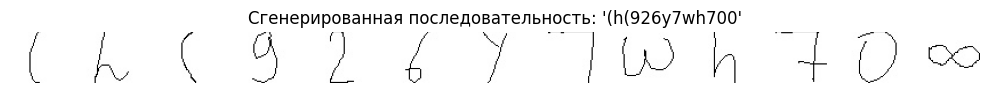

In [33]:
generator = SequenceGenerator(char_dataset)
# Генерируем последовательность
true_sequence, labels = generator.generate_random_sequence()
sequence_image = generator.create_sequence_image(true_sequence, labels)

# Выводим информацию о генерации
print("=== ГЕНЕРАЦИЯ ПОСЛЕДОВАТЕЛЬНОСТИ ===")
print(f"Сгенерирована последовательность: {''.join(true_sequence)}")
print(f"Длина последовательности: {len(true_sequence)}")

# Визуализируем сгенерированное изображение

visual.visualize_generated_sequence(sequence_image, true_sequence)

# КЛАССИФИКАЦИЯ

### Классификатор

In [34]:
class CharClassifier:
    def __init__(self, char_dataset):
        self.char_dataset = char_dataset
        self.model = None
        self.best_k = None
        self.accuracy_history = {}

        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.char_labels = None

    
    def _preprocess_image(self, img):
        if len(img.shape) == 3:
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            img_gray = img.copy()
        
        kernel = np.ones((3,3), np.uint8)
        img_gray = cv2.erode(img_gray, kernel, iterations=1)
        img_gray = cv2.bitwise_not(img_gray)
        
        base_size = (img_gray.shape[0] + 6, img_gray.shape[1] + 6)
        base = np.zeros(base_size, dtype=np.uint8)
        base[3:img_gray.shape[0] + 3, 3:img_gray.shape[1] + 3] = img_gray

        base = cv2.resize(base, (img.shape[0], img.shape[0]))
        return base

    def prepare_data(self, test_size=0.3, random_state=42, apply_preprocessing=True):
        X, y, chars = self.char_dataset.get_all_data()
        if apply_preprocessing:
            X_processed = []
            for i in range(len(X)):
                processed_img = self._preprocess_image(X[i])
                X_processed.append(processed_img)
            X = np.array(X_processed)

        n_samples = len(X)
        if len(X.shape) == 3:  # (n_samples, height, width)
            X_flat = X.reshape((n_samples, -1))
        elif len(X.shape) == 4:  # (n_samples, height, width, channels)
            X_flat = X.reshape((n_samples, -1))

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X_flat, y, test_size=test_size, random_state=random_state, stratify=y
        )
        self.char_labels = chars
        return self.X_train, self.X_test, self.y_train, self.y_test
    
    def find_optimal_k(self, k_range=None):
        if k_range is None:
            k_range = range(1, 10, 2)
        
        best_accuracy = 0
        best_k = 3

        for k in k_range:
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(self.X_train, self.y_train)
            y_pred = knn.predict(self.X_test)
            accuracy = accuracy_score(self.y_test, y_pred)
            self.accuracy_history[k] = accuracy

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_k = k
        
        self.best_k = best_k
        return best_k, best_accuracy, self.accuracy_history
    
    def train_best_model(self):
        if self.best_k is None:
            self.find_optimal_k()

        self.model = KNeighborsClassifier(n_neighbors=self.best_k)
        self.model.fit(self.X_train, self.y_train)
        return self.model
    
    def evaluate_model(self):
        if self.model is None:
            self.train_best_model()
        
        y_pred = self.model.predict(self.X_test)
        accuracy = accuracy_score(self.y_test, y_pred)
        cm = confusion_matrix(self.y_test, y_pred)
        return accuracy, cm, y_pred
    
    def get_data_info(self):
        X, y, chars = self.char_dataset.get_all_data()
        info = {
            'original_distribution': np.unique(y, return_counts=True),
            'data_shape': X.shape,
            'char_labels': chars,
            'n_classes': len(chars)
        }
        if self.X_train is not None:
            info.update({
                'train_distribution': np.unique(self.y_train, return_counts=True),
                'test_distribution': np.unique(self.y_test, return_counts=True),
                'train_size': len(self.X_train),
                'test_size': len(self.X_test)
            })
        return info

    def get_error_analysis(self, y_pred):
        errors = y_pred != self.y_test
        error_indices = np.where(errors)[0]
        
        if len(error_indices) == 0:
            return {'total_errors': 0}
        
        error_pairs = []
        for idx in error_indices:
            true_label = self.y_test[idx]
            pred_label = y_pred[idx]
            error_pairs.append((true_label, pred_label))
        
        from collections import Counter
        common_errors = Counter(error_pairs).most_common(10)
        
        analysis = {
            'total_errors': len(error_indices),
            'common_errors': common_errors,
            'char_labels': self.char_labels
        }
        
        return analysis
    
    def predict_single_image(self, image):
        if self.model is None:
            raise ValueError("Модель не обучена. Сначала вызовите train_best_model()")
        
        if len(image.shape) == 3:
            image_flat = image.reshape(1, -1)
        else:
            image_flat = image.flatten().reshape(1, -1)
        
        prediction = self.model.predict(image_flat)[0]
        probability = self.model.predict_proba(image_flat)[0]
        
        predicted_char = self.char_labels[prediction]
        confidence = probability[prediction]
        return predicted_char, confidence, probability

### Пример использования

In [35]:
classifier = CharClassifier(char_dataset)

print("=== ПОДГОТОВКА ДАННЫХ ===")
classifier.prepare_data(test_size=0.3, apply_preprocessing=True)
visual.print_data_preparation_info(classifier)

=== ПОДГОТОВКА ДАННЫХ ===
=== ДИАГНОСТИКА РАСПРЕДЕЛЕНИЯ МЕТОК ===

Форма данных: (225291, 45, 45, 3)
Количество классов: 21

Распределение после разделения:
Обучающая выборка:
  Метка 0 ('('): 10006 образцов
  Метка 1 (')'): 10048 образцов
  Метка 2 ('+'): 17578 образцов
  Метка 3 (','): 1334 образцов
  Метка 4 ('-'): 23798 образцов
  Метка 5 ('0'): 4840 образцов
  Метка 6 ('1'): 18564 образцов
  Метка 7 ('2'): 18299 образцов
  Метка 8 ('3'): 7636 образцов
  Метка 9 ('4'): 5177 образцов
  Метка 10 ('5'): 2481 образцов
  Метка 11 ('6'): 2182 образцов
  Метка 12 ('7'): 2036 образцов
  Метка 13 ('8'): 2148 образцов
  Метка 14 ('9'): 440 образцов
  Метка 15 ('X'): 18616 образцов
  Метка 16 ('h'): 1025 образцов
  Метка 17 ('t'): 2292 образцов
  Метка 18 ('*'): 2276 образцов
  Метка 19 ('w'): 389 образцов
  Метка 20 ('y'): 6538 образцов
Тестовая выборка:
  Метка 0 ('('): 4288 образцов
  Метка 1 (')'): 4307 образцов
  Метка 2 ('+'): 7534 образцов
  Метка 3 (','): 572 образцов
  Метка 4 ('-'):

In [36]:
print("\n=== ПОИСК ОПТИМАЛЬНОГО k ===")
k_range = range(1, 10, 2)
print("Поиск оптимального k...")
print("k\tAccuracy")
print("-" * 15)
best_k, best_accuracy, accuracy_history = classifier.find_optimal_k(k_range)
visual.print_optimal_k_search(best_k, best_accuracy, accuracy_history, k_range)

print(f"Количество классов: {len(classifier.char_labels)}")
print(f"Размерность признаков: {classifier.X_train.shape[1]}")


=== ПОИСК ОПТИМАЛЬНОГО k ===
Поиск оптимального k...
k	Accuracy
---------------
1	0.9937
3	0.9721
5	0.9453
7	0.9357
9	0.9278

Оптимальное k: 1 с точностью 0.9937
Количество классов: 21
Размерность признаков: 2025


In [37]:
print("\n=== ОБУЧЕНИЕ МОДЕЛИ ===")
classifier.train_best_model()
print(f"Модель обучена с k={classifier.best_k}")


=== ОБУЧЕНИЕ МОДЕЛИ ===
Модель обучена с k=1



=== ОЦЕНКА МОДЕЛИ ===
Точность (accuracy) на тестовой выборке: 0.9937

Отчет классификации:
              precision    recall  f1-score   support

           (       0.99      0.99      0.99      4288
           )       0.99      1.00      0.99      4307
           +       1.00      1.00      1.00      7534
           ,       0.85      0.94      0.89       572
           -       1.00      1.00      1.00     10199
           0       1.00      1.00      1.00      2074
           1       0.99      0.99      0.99      7956
           2       1.00      1.00      1.00      7842
           3       0.99      1.00      0.99      3273
           4       1.00      0.99      0.99      2219
           5       1.00      0.99      0.99      1064
           6       0.99      0.98      0.98       936
           7       1.00      0.98      0.99       873
           8       1.00      0.98      0.99       920
           9       0.98      0.78      0.87       188
           X       1.00      1.00      1.0

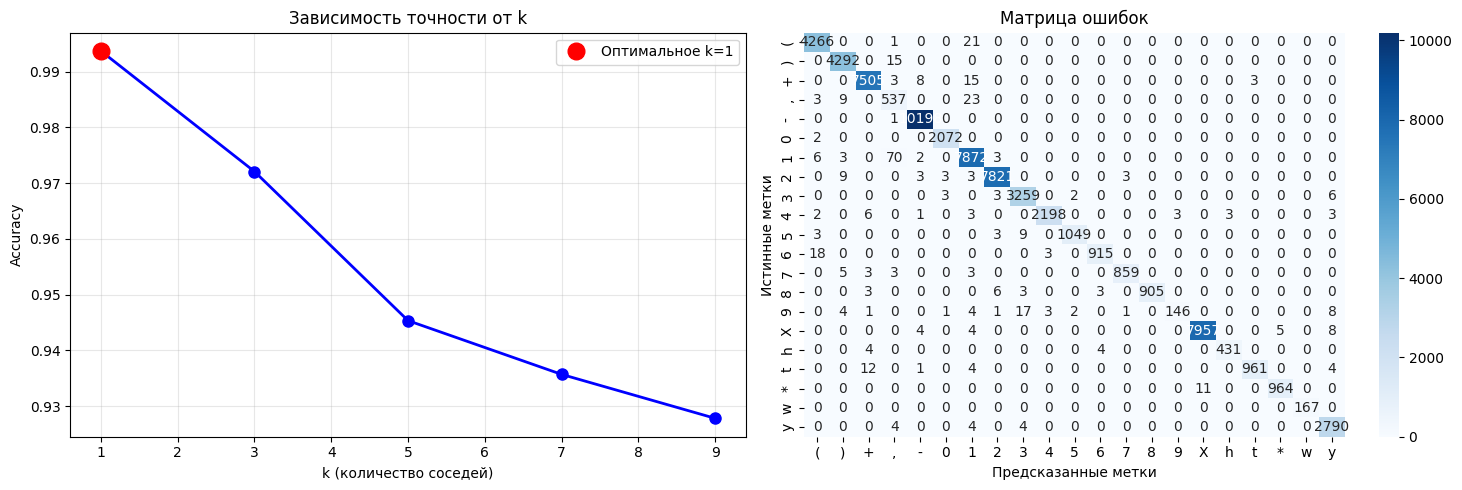


=== ПРИМЕРЫ ПРЕДСКАЗАНИЙ ===


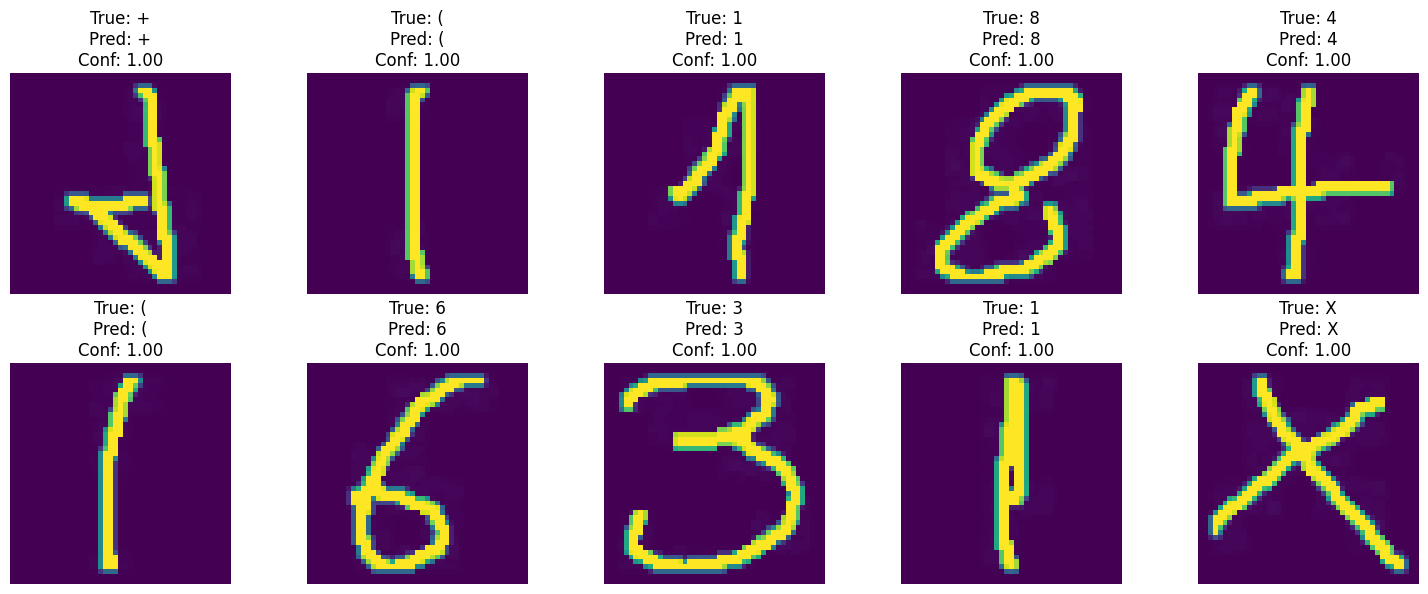

In [38]:
print("\n=== ОЦЕНКА МОДЕЛИ ===")
accuracy, cm, y_pred = visual.print_model_evaluation(classifier, detailed_analysis=True)

print("\n=== ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ ===")
visual.plot_results(classifier)

print("\n=== ПРИМЕРЫ ПРЕДСКАЗАНИЙ ===")
visual.show_sample_predictions(classifier, 10)

# РАСПОЗНАВАНИЕ

In [39]:

class SequenceRecognizer:
    def __init__(self, knn_classifier, char_dataset):
        self.knn_classifier = knn_classifier
        self.char_dataset = char_dataset
        self.char_labels = char_dataset.available_chars
    
    def _preprocess_char(self, img_char):
        """предобработка изображения символа"""
        target_size = self.char_dataset.img_size

        if len(img_char.shape) == 3:
            img_char = cv2.cvtColor(img_char, cv2.COLOR_BGR2GRAY)
        
        h, w = img_char.shape
        result = np.zeros((target_size, target_size), dtype=img_char.dtype)
        
        scale_h = target_size / h
        scale_w = target_size / w
        scale = min(scale_h, scale_w)
        
        new_h = int(h * scale)
        new_w = int(w * scale)
        
        if scale != 1.0:
            resized_img = cv2.resize(img_char, (new_w, new_h), interpolation=cv2.INTER_AREA)
        else:
            resized_img = img_char
        
        y_offset = (target_size - new_h) // 2
        x_offset = (target_size - new_w) // 2
        
        result[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized_img
        
        return result

    def _preprocess_input_image(self, img):
        if len(img.shape) == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        kernel = np.ones((3,3), np.uint8)
        img_gray = cv2.erode(img_gray, kernel, iterations=2)
        img_gray = cv2.bitwise_not(img_gray)
        

        base_size = (img_gray.shape[0] + 12, img_gray.shape[1] + 12)
        base = np.zeros(base_size, dtype=np.uint8)
        base[3:img_gray.shape[0] + 3, 3:img_gray.shape[1] + 3] = img_gray
        base = cv2.cvtColor(base, cv2.COLOR_GRAY2RGB)
        return base, img_gray
    
    def _detect_characters(self, img_rgb, img_gray):
        ret, thresh = cv2.threshold(img_rgb, 127, 255, 0)
        thresh = np.uint8(thresh)
        
        contours, _ = cv2.findContours(thresh[:,:,0], cv2.RETR_EXTERNAL, 2)
        crops = []
        img_with_boxes = img_rgb.copy()

        for cnt in contours:
            area = cv2.contourArea(cnt)
            x, y, w, h = cv2.boundingRect(cnt)

            if w * h > 50:
                cv2.rectangle(img_with_boxes,(x,y),(x+w,y+h),(0,0,255),1)
                ret,thresh = cv2.threshold(img_gray[y:y+h, x:x+w],127,255,0)
                crops.append([x,y,w,h]) 
        return crops, img_with_boxes
    
    def _extract_and_preprocess_chars(self, crops, img_gray):
        data_img = []
        for i in range(len(crops)):
            x,y,w,h = crops[i]
            x-=3
            y-=3
            w+=5
            h+=3
            img = img_gray[y:y+h, x:x+w]
            base_size=img.shape[0]+2,img.shape[1]+30
            base=np.zeros(base_size,dtype=np.uint8)
            base[1:img.shape[0]+1,15:img.shape[1]+15]=img
            base = self._preprocess_char(base)
            data_img.append((x,base))
        return data_img

    def _classify_characters(self, data_img):
        sorted_chars = sorted(data_img, key=lambda item: item[0])
        predictions = []
        confidence_scores = []
        
        for x, char_img in sorted_chars:
            char_vector = char_img.reshape(1, -1)
            predicted_char, confidence, _ = self.knn_classifier.predict_single_image(char_vector)
            predictions.append(predicted_char)
            confidence_scores.append(confidence)
        
        return sorted_chars, predictions, confidence_scores
    
    def recognize_sequence(self, image):
        """Пайплайн распознавания"""
        img_rgb, img_gray = self._preprocess_input_image(image)
        crops, img_with_boxes = self._detect_characters(img_rgb, img_gray)
        
        if len(crops) == 0:
            return "", [], [], img_rgb, img_with_boxes, []
        data_img = self._extract_and_preprocess_chars(crops, img_gray)
        sorted_chars, predictions, confidence_scores = self._classify_characters(data_img)
        result_string = ''.join(predictions)
        return result_string, predictions, confidence_scores, img_rgb, img_with_boxes, sorted_chars

    def get_recognition_stats(self, confidence_scores):
        """Статистика распознавания"""
        return {
            'mean_confidence': np.mean(confidence_scores) if confidence_scores else 0,
            'min_confidence': np.min(confidence_scores) if confidence_scores else 0,
            'max_confidence': np.max(confidence_scores) if confidence_scores else 0,
            'num_chars': len(confidence_scores)
        }



## Итоговый пайплайн

=== ГЕНЕРАЦИЯ ПОСЛЕДОВАТЕЛЬНОСТИ ===
Сгенерирована последовательность: h(1
Длина последовательности: 3


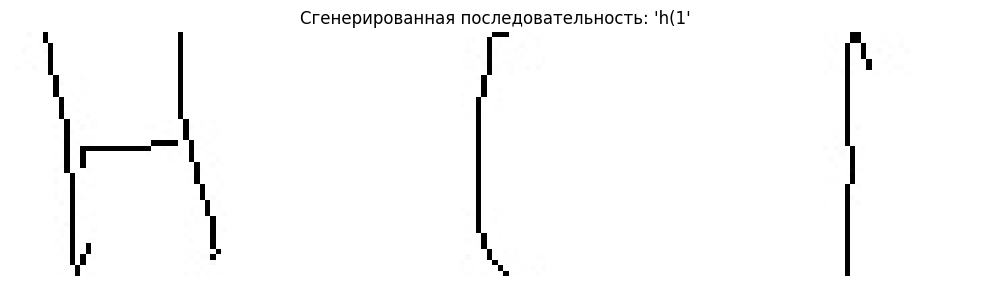

=== ШАГ 1: ПОЛУЧЕНИЕ ИЗОБРАЖЕНИЯ ОТ ГЕНЕРАТОРА ===
Сгенерированная последовательность: h(1
=== ШАГ 2: ПРЕДОБРАБОТКА ИЗОБРАЖЕНИЯ ===
=== ШАГ 3: ВЫДЕЛЕНИЕ СИМВОЛОВ ===
Обнаружено символов: 3
=== ШАГ 4: КЛАССИФИКАЦИЯ k-NN ===


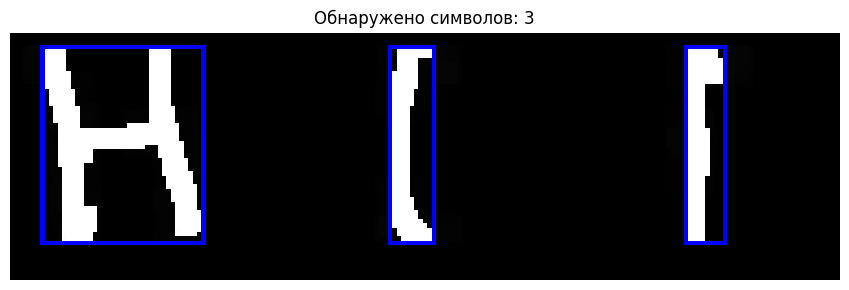

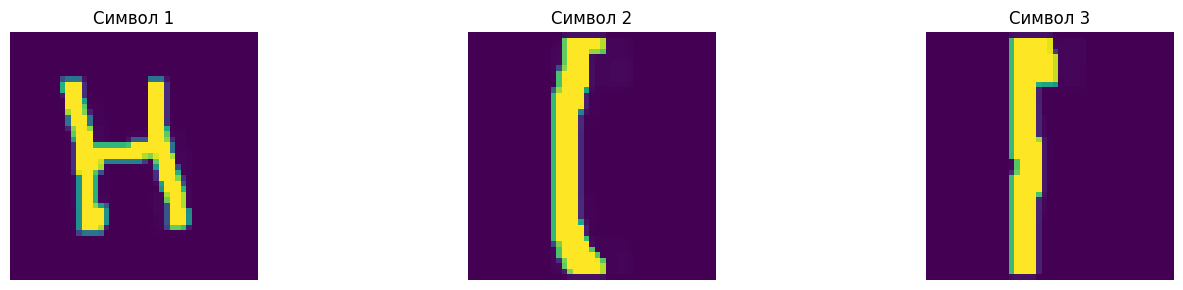

Символ 1: 'h' (уверенность: 1.000) ✓
Символ 2: '(' (уверенность: 1.000) ✓
Символ 3: '1' (уверенность: 1.000) ✓
=== ШАГ 5: ФОРМИРОВАНИЕ РЕЗУЛЬТАТА ===

ИСТИННАЯ ПОСЛЕДОВАТЕЛЬНОСТЬ: h(1
РАСПОЗНАННАЯ ПОСЛЕДОВАТЕЛЬНОСТЬ: h ( 1
ТОЧНОСТЬ РАСПОЗНАВАНИЯ: 1.000
СРЕДНЯЯ УВЕРЕННОСТЬ: 1.000
КОЛИЧЕСТВО СИМВОЛОВ: 3


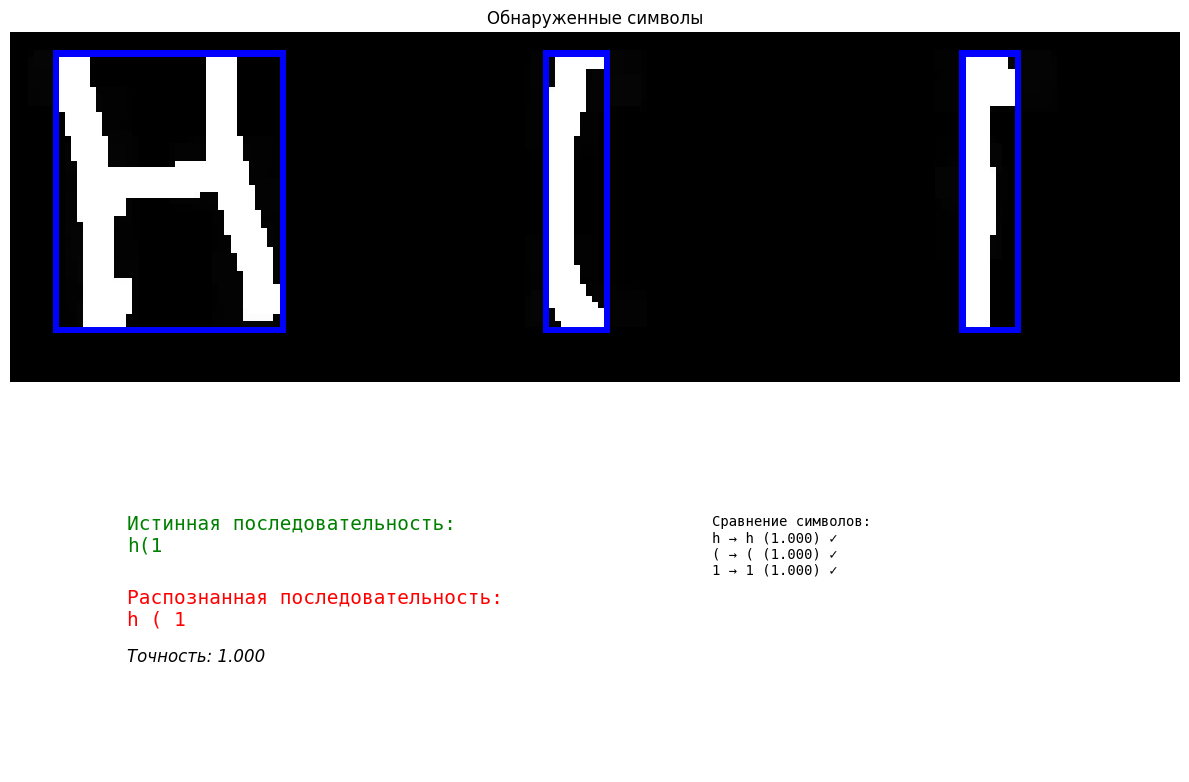

In [ ]:
recognizer = SequenceRecognizer(classifier, char_dataset)
generator = SequenceGenerator(char_dataset, max_length=5)

true_sequence, labels = generator.generate_random_sequence()
sequence_image = generator.create_sequence_image(true_sequence, labels)


print("=== ГЕНЕРАЦИЯ ПОСЛЕДОВАТЕЛЬНОСТИ ===")
print(f"Сгенерирована последовательность: {''.join(true_sequence)}")
print(f"Длина последовательности: {len(true_sequence)}")


visual.visualize_generated_sequence(sequence_image, true_sequence)

result_string, predictions, confidence_scores, img_rgb,\
img_with_boxes, sorted_chars = recognizer.recognize_sequence(sequence_image)

visual.print_recognition_steps(true_sequence, len(sorted_chars))


visual.visualize_detection(img_with_boxes, len(sorted_chars))

if sorted_chars:
    visual.visualize_extracted_chars(sorted_chars)

if predictions:
    visual.print_classification_results(predictions, confidence_scores, true_sequence)

    final_result = visual.post_process_result(predictions, confidence_scores)

    visual.print_final_result(final_result, true_sequence, predictions, confidence_scores)


    visual.visualize_comparison_result(img_with_boxes, true_sequence, predictions, 
                                    confidence_scores, final_result)
else:
    print("Не обнаружено символов для распознавания!")